# Understanding Autograd 

Automatic differentiation is a way to compute gradients of a function with respect to its input variables. PyTorch provides a module, `autograd`, for automatic differentiation. In this notebook, we will understand how `autograd` works by implementing a simple neural network from scratch.

Let's first create a Variable class that will store the data and the gradient of the data. We will also define a function to compute the gradients of the loss with respect to the input data.

In [10]:
class Variable:
    def __init__(self, data, _children=(), _op=None):
        self.data = float(data)
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
    

    def backward(self):
        stack = [self]
        visited = set([self])

        while stack:
            node = stack.pop()
            node._backward()
            for parent in node._prev:
                if parent not in visited:
                    stack.append(parent)
                    visited.add(parent)

    def __add__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.data + other.data, (self, other), _op="add")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.data * other.data, (self, other), _op="mul")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Variable(data={self.data}, grad={self.grad})"
    
    def __str__(self):
        return f"{self.data}"

Let's now build s computational graph to understand. Let's build a simple linear equation, $y = 2x + 3$. We will compute the gradients of $y$ with respect to $x$. Let's visualize the computational graph for this equation.

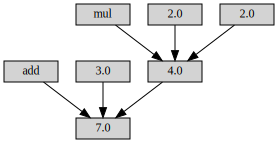

In [14]:
import graphviz

# Create a graphviz graph such that each variable and op are nodes and the edges are the dependencies
def make_dot(var):
    node_attr = dict(style='filled', shape='box', align='left', fontsize='12', ranksep='0.1', height='0.2')
    dot = graphviz.Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            dot.node(str(id(var)), label=str(var.data))
            seen.add(var)
            if var._op:
                dot.node(str(id(var)) + var._op, label=var._op)
                dot.edge(str(id(var)) + var._op, str(id(var)))
            for child in var._prev:
                dot.edge(str(id(child)), str(id(var)))
                add_nodes(child)

    add_nodes(var)
    return dot

x = Variable(2.0)
y = x * 2 + 3

make_dot(y)

In [3]:
# build a computation graph fro y = 2x + 3
x = Variable(2)
y = x * 2 + 3

# backprop
y.grad = 1.0
y.backward()

print(x.grad) # 2
print(y.grad) # 1

2.0
1.0
